# Bitcoin Price Forecasting Using Multi-Feature GRU Neural Network — Sequence-to-Sequence Prediction

This notebook demonstrates how to forecast Bitcoin closing prices using a deep learning sequence-to-sequence model with Gated Recurrent Units (GRU). Leveraging multiple historical features — including Open, High, Low, Close, and Volume — the model is trained to predict the next 10 days of closing prices based on the preceding 30 days of data. The workflow covers data preprocessing with MinMax scaling, sequence generation, model architecture design with stacked bidirectional GRUs, training, and visualization of predicted versus actual price sequences. This end-to-end approach provides a practical example of time series forecasting in the financial domain using recurrent neural networks.

## Install Libraries

In [304]:
%pip install yfinance matplotlib scikit-learn tensorflow

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Brian\OneDrive - University of Witwatersrand\Desktop\off_the_grid\tutorials\technical_analysis\GRU_bitcoin_forecasting\venv\Scripts\python.exe -m pip install --upgrade pip' command.


## Import Libraries

In [305]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, TimeDistributed, RepeatVector

import os

# Set up directory to save figures
os.makedirs("figures", exist_ok=True)

plt.style.use("dark_background")

## Download Data

In [306]:
# Download historical BTC-USD data
df = yf.download('BTC-USD', start='2014-01-01')
df = df[['Close', 'High', 'Low', 'Open', 'Volume']]
df.dropna(inplace=True)
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800
2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200
2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700
2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600
2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100


## Plot Closing Price

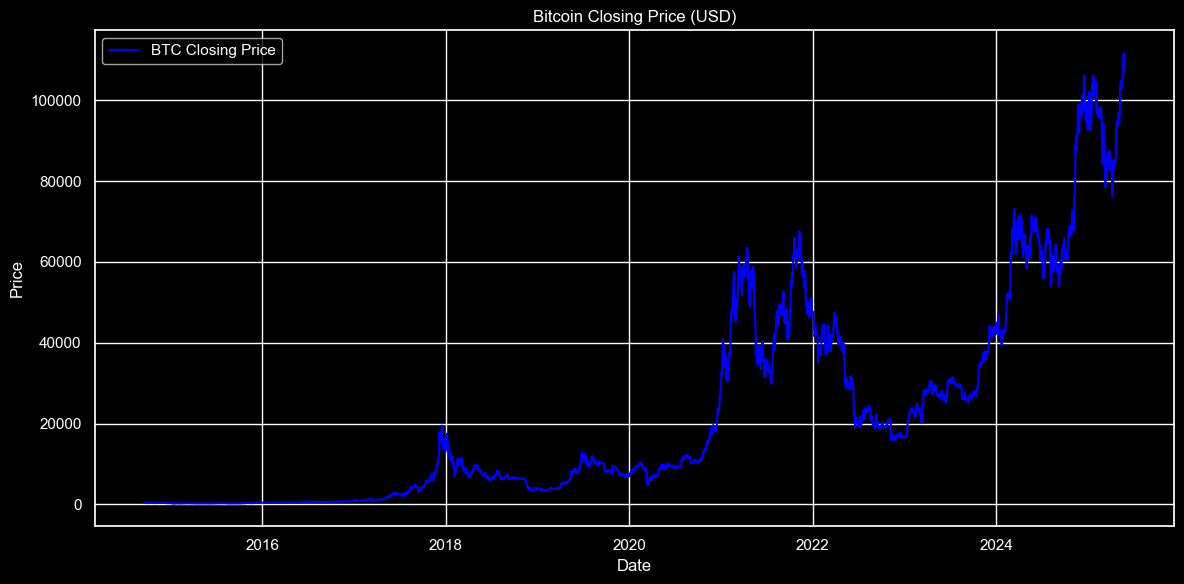

In [307]:
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='BTC Closing Price', color='blue')
plt.title('Bitcoin Closing Price (USD)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.savefig('figures/closing_price.png')
plt.show()

## Scale Data

In [308]:
# Scale all features for input
feature_scaler = MinMaxScaler()
scaled_features = feature_scaler.fit_transform(df[['Close', 'High', 'Low', 'Open', 'Volume']].values)

# Scale only the target (Close) for output
target_scaler = MinMaxScaler()
scaled_target = target_scaler.fit_transform(df[['Close']].values)

## Create Sequences for (seq2seq)

In [309]:
sequence_length = 30
forecast_horizon = 5

X, y = [], []

for i in range(sequence_length, len(df) - forecast_horizon + 1):
    # Input: all features
    X.append(scaled_features[i - sequence_length:i])
    
    # Output: only 'Close' from scaled_target
    y.append(scaled_target[i:i + forecast_horizon].flatten())

X, y = np.array(X), np.array(y)

## Split Data into train and test sets

In [310]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("Training shape:", X_train.shape, y_train.shape)
print("Testing shape:", X_test.shape, y_test.shape)

Training shape: (3097, 30, 5) (3097, 5)
Testing shape: (775, 30, 5) (775, 5)


## Visulize example input and target

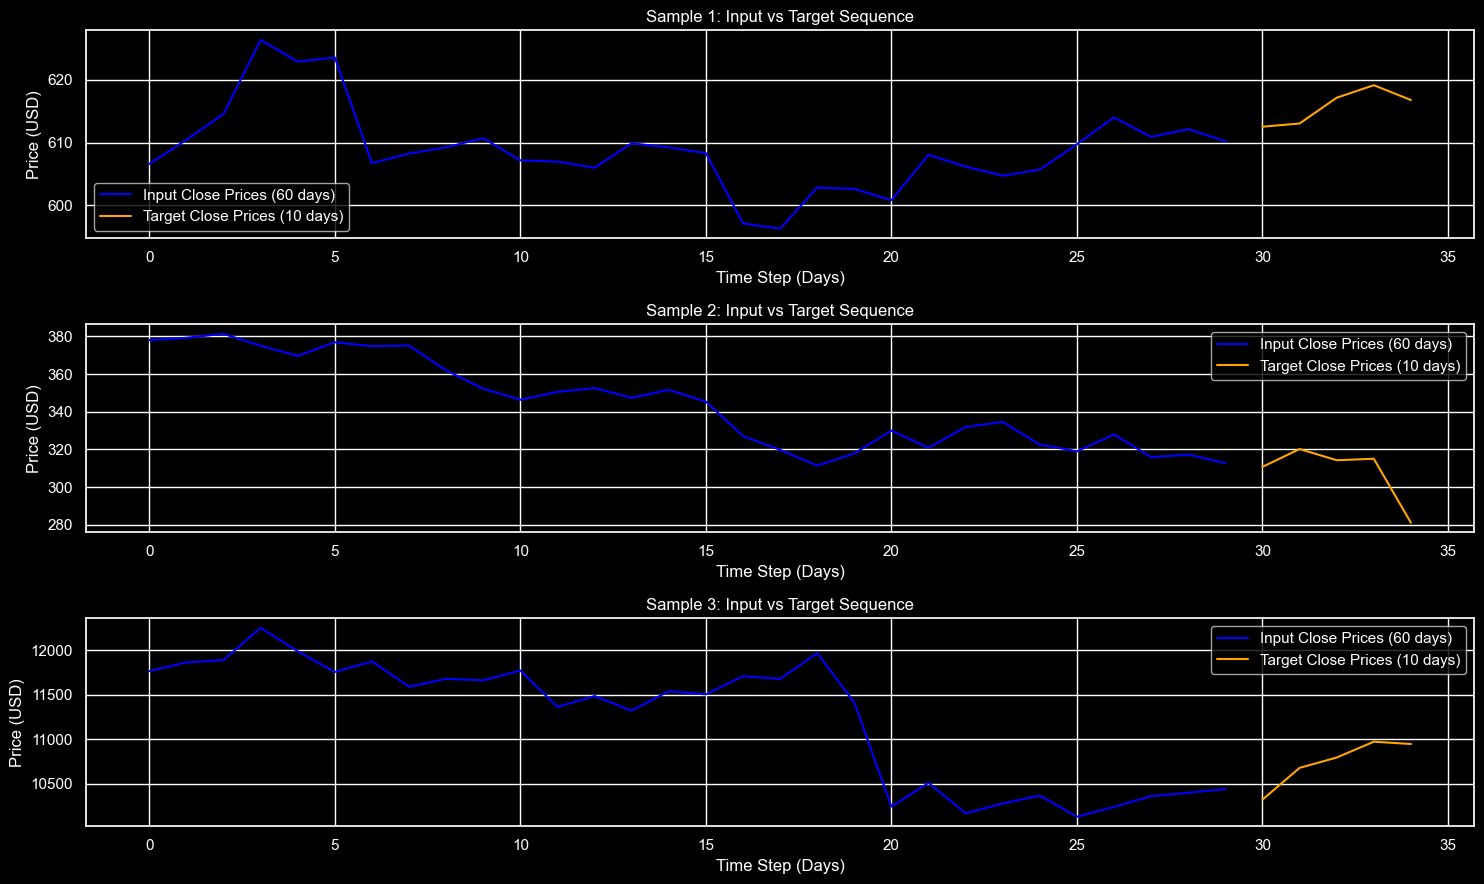

In [311]:
num_samples = 3
plt.figure(figsize=(15, num_samples * 3))

for i in range(num_samples):
    idx = np.random.randint(0, len(X_train))
    
    # Only invert 'Close' feature (index 0) from input
    input_seq = feature_scaler.inverse_transform(X_train[idx])[:, 0]  # Close only
    target_seq = target_scaler.inverse_transform(y_train[idx].reshape(-1, 1)).flatten()

    plt.subplot(num_samples, 1, i + 1)
    plt.plot(range(sequence_length), input_seq, label='Input Close Prices (60 days)', color='blue')
    plt.plot(range(sequence_length, sequence_length + forecast_horizon), target_seq, color='orange', label='Target Close Prices (10 days)')
    plt.title(f"Sample {i + 1}: Input vs Target Sequence")
    plt.xlabel("Time Step (Days)")
    plt.ylabel("Price (USD)")
    plt.legend()

plt.tight_layout()
plt.savefig("figures/train_input_vs_target_seq2seq.png")
plt.show()


## Compile the GRU model

In [312]:
model = Sequential([
    GRU(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    RepeatVector(forecast_horizon),
    GRU(64, return_sequences=True),
    TimeDistributed(Dense(1))
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


c:\Users\Brian\OneDrive - University of Witwatersrand\Desktop\off_the_grid\tutorials\technical_analysis\GRU_bitcoin_forecasting\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_48 (GRU)                    │ (None, 64)             │        13,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_18 (RepeatVector) │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_49 (GRU)                    │ (None, 5, 64)          │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_18             │ (None, 5, 1)           │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,657 (151.00 KB)

 Trainable params: 38,657 (151.00 KB)

 Non-trainable params: 0 (0.00 B)

## Start Training

In [313]:
history = model.fit(
    X_train, y_train.reshape(-1, forecast_horizon, 1),
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test.reshape(-1, forecast_horizon, 1))
)


Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0054 - val_loss: 0.0024
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.7576e-04 - val_loss: 0.0011
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.9057e-04 - val_loss: 0.0019
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.9678e-04 - val_loss: 8.2332e-04
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2.1182e-04 - val_loss: 0.0010
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.9899e-04 - val_loss: 0.0012
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.0583e-04 - val_loss: 0.0015
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.7780e-04 - val_loss: 0.0013
Epoch 9/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.7600e-04 - val_loss: 8.1490e-04
Epoch 10/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.8146e-04 - val_loss: 0.0012
Epoch 11/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.7905e-04 - val_loss: 0.0017
Epoc

## Visualize Training Loss

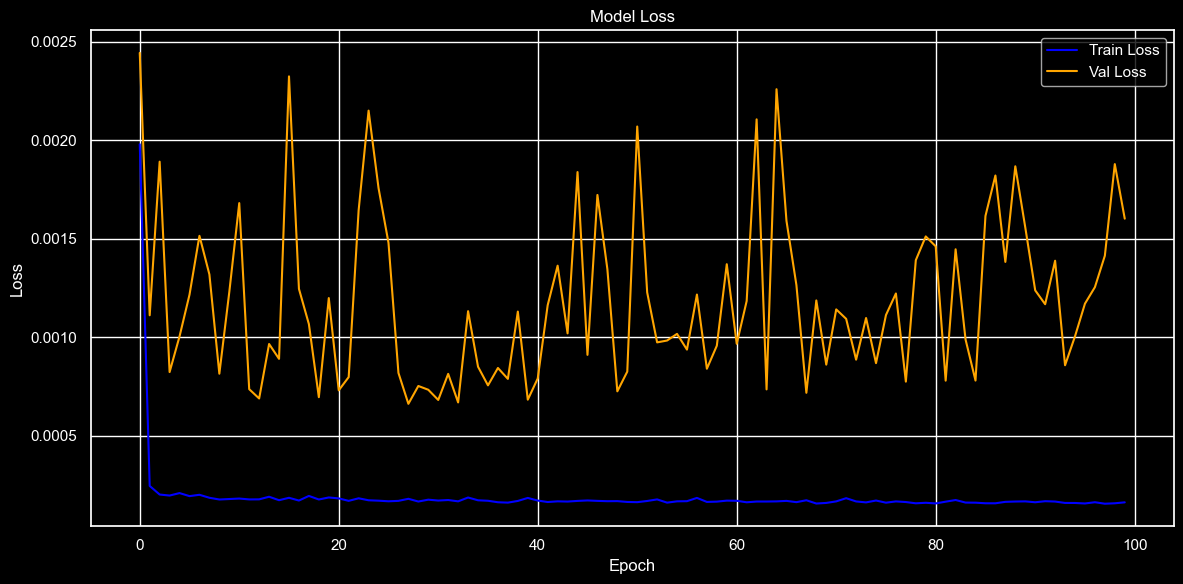

In [314]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('figures/training_loss_seq2seq.png')
plt.show()


## Generate Predictions

In [315]:
predicted = model.predict(X_test)

# Inverse transform predicted and real Close prices
predicted_prices = target_scaler.inverse_transform(predicted.reshape(-1, 1)).reshape(-1, forecast_horizon)
real_prices = target_scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(-1, forecast_horizon)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


## Visualize Predictions

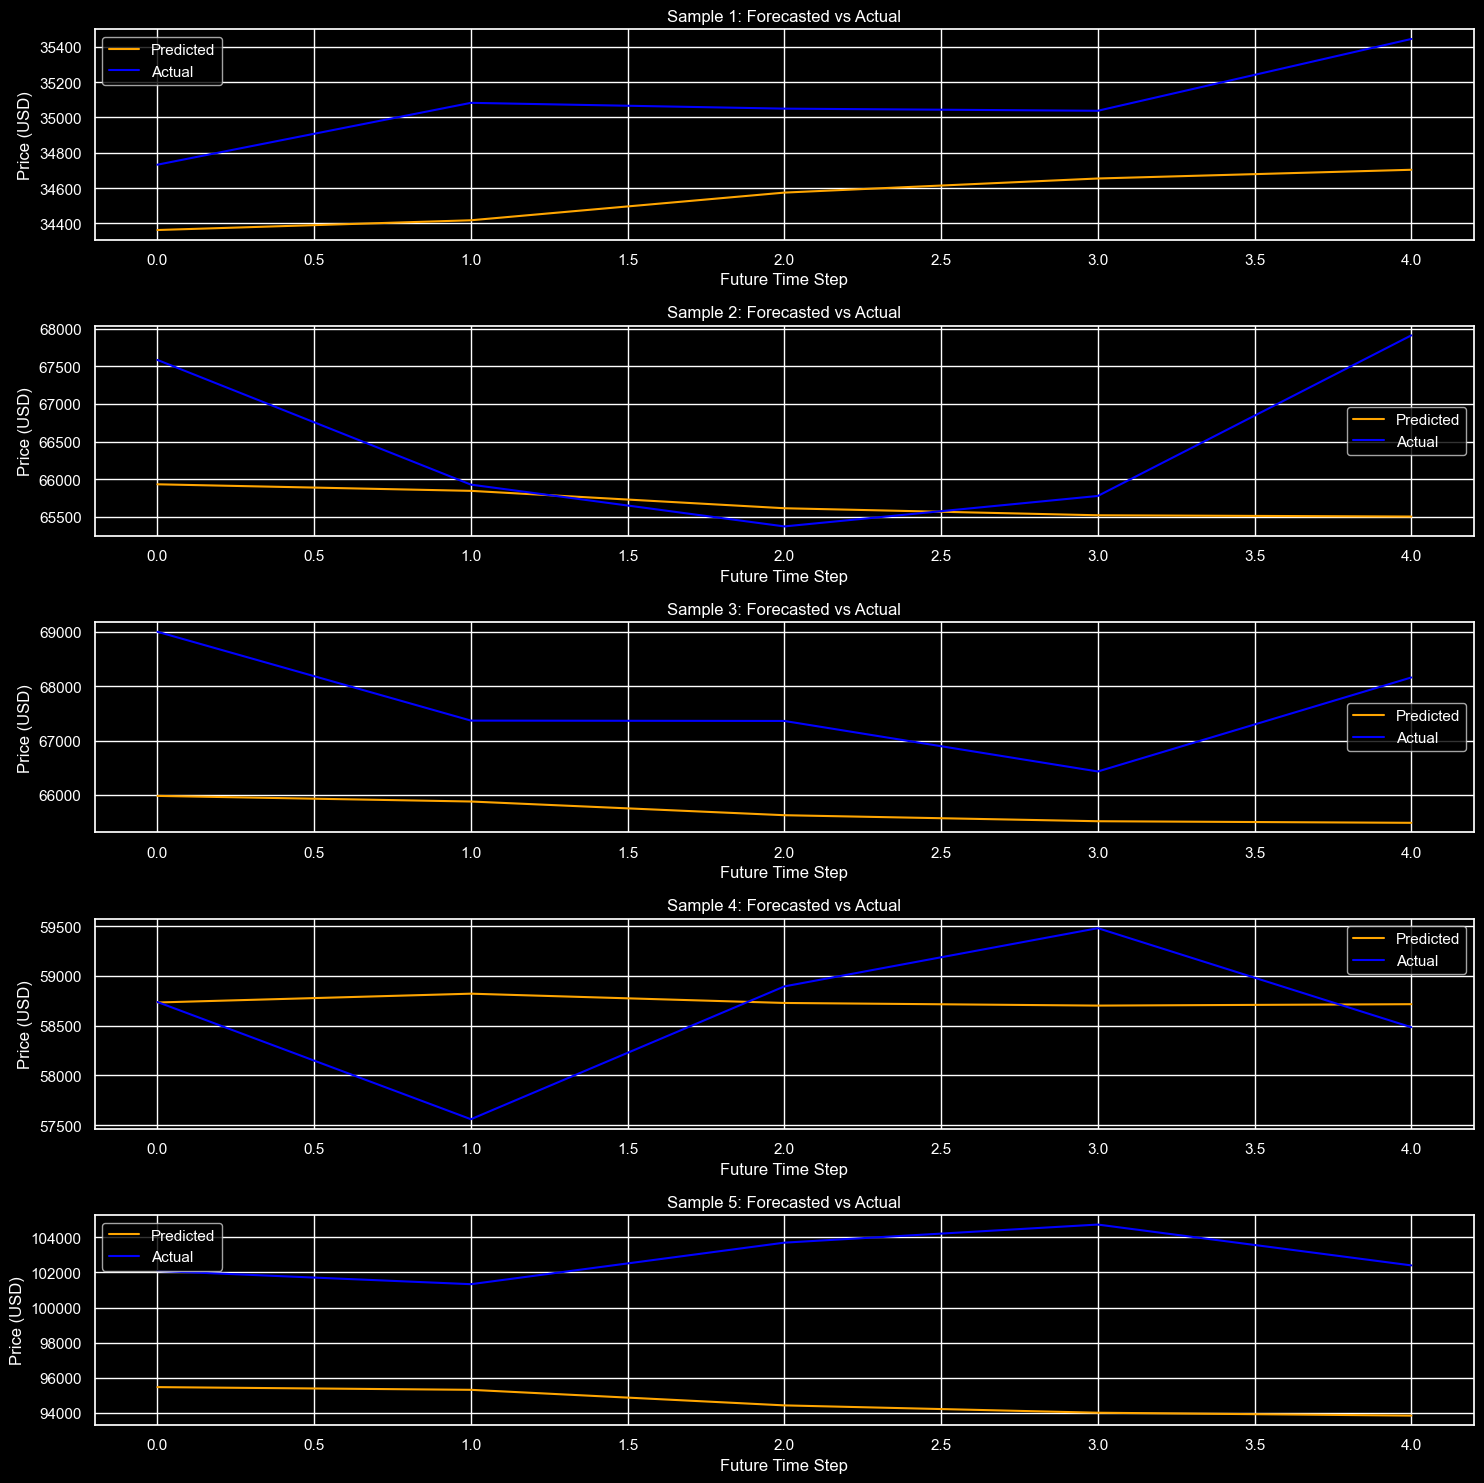

In [316]:
num_samples = 5
plt.figure(figsize=(15, num_samples * 3))

for i in range(num_samples):
    idx = np.random.randint(0, len(predicted_prices))  # Randomly pick an index
    plt.subplot(num_samples, 1, i + 1)
    plt.plot(predicted_prices[idx], label='Predicted', color='orange')
    plt.plot(real_prices[idx], label='Actual', color='blue')
    plt.title(f"Sample {i + 1}: Forecasted vs Actual")
    plt.xlabel("Future Time Step")
    plt.ylabel("Price (USD)")
    plt.legend()

plt.tight_layout()
plt.savefig("figures/predicted_vs_actual_seq2seq.png")
plt.show()

## Evaluate Model Perfomance

In [317]:
flat_pred = predicted_prices.flatten()
flat_real = real_prices.flatten()

mse = mean_squared_error(flat_real, flat_pred)
mae = mean_absolute_error(flat_real, flat_pred)
rmse = np.sqrt(mse)
r2 = r2_score(flat_real, flat_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


Mean Absolute Error (MAE): 3127.02
Mean Squared Error (MSE): 19910244.90
Root Mean Squared Error (RMSE): 4462.09
R² Score: 0.9689


## Save Model

In [318]:
model.save('bitcoin_gru_model.h5')